In [1]:
import numpy as np
import pandas as pd
import ta
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
dd = pd.read_excel("Index/data.xlsx")
dd = dd.set_index('Date')
dd =dd.drop(columns='Unnamed: 0')

In [3]:
def Calculate_TA_and_label(dd,c):
    dd['Highest_Close']=dd['High'].rolling(window=26).max()
    dd['Lowest_Close']=dd['Low'].rolling(window =26).min()
    dd['RSI']=ta.momentum.RSIIndicator(dd['Close'], window  = 10, fillna = False).rsi()
    dd['MACD']=ta.trend.macd_diff(dd['Close'], window_slow=26,window_fast=12,fillna= False)
    dd['MA_slow']=((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=30).mean()
    dd['MA'] = ((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=20).mean()
    dd['Volume_AVG'] = dd['Volume'].rolling(window=30).mean()
    dd['Low_band'] = dd['Low'].rolling(window=9).mean()
    dd['High_band'] = dd['High'].rolling(window=9).mean()
    dd['Close_only'] = dd['Close'].rolling(window=20).mean()
    dd['Sto_RSI']= (dd['RSI']-dd['RSI'].rolling(window=14).min())/(dd['RSI'].rolling(window=14).max()-dd['RSI']+0.1)
    dd['MA_RSI']= dd['RSI'].rolling(window=14).mean()
    dd['EMA']=ta.trend.ema_indicator(dd['Close'], window = 20, fillna = False)
    #dd['CCI'] = ta.trend.cci(dd['High'],dd['Low'],dd['Close'], window=25,constant=0.015,fillna=False)
    #dd['ROCI']=ta.momentum.ROCIndicator(dd['Close'], window = 12, fillna = False).roc()
    dd['TSI']=ta.momentum.TSIIndicator(dd['Close'], window_slow = 25, window_fast = 13, fillna = False).tsi()
    #dd['MACD_signal']=ta.trend.macd_signal(dd['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False)
    #dd['KAMA']=ta.momentum.KAMAIndicator(dd['Close'], window = 10, pow1 = 2, pow2 = 30, fillna = False).kama()
    dd['MFI']=ta.volume.MFIIndicator(dd['High'],dd['Low'],dd['Close'],dd['Volume'], window = 18, fillna = False).money_flow_index()
    dd['BB_high']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    dd['BB_high_RSI']=ta.volatility.BollingerBands(dd['RSI'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low_RSI']=ta.volatility.BollingerBands(dd['RSI'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    dd['BB_high_vol']=ta.volatility.BollingerBands(dd['Volume'], window = 20, window_dev = 1.5, fillna = False).bollinger_hband()
    dd['BB_low_vol']=ta.volatility.BollingerBands(dd['Volume'], window = 20, window_dev = 1.5, fillna = False).bollinger_lband()
    #dd['WMA']=ta.trend.WMAIndicator(dd['Close'], window = 20, fillna = False).wma()
    # đoạn này là bắt đầu khoai r vì nhìn thì nhiều nhưng thực ra tất cả đều không có quá khó hiểu chỉ là bản chất nó khá là rắc rối :Vvv
    # tớ sẽ giải thích 1 vài chỉ báo trong đống này
    dd['ATR'] =ta.volatility.AverageTrueRange(dd['High'],dd['Low'],dd['Close'],window=14,fillna= False).average_true_range()
    dd['High_Low'] = (dd['High']+dd['Low'])/2
    dd['upper_band'] = dd['High_Low']+2*dd['ATR']
    dd['lower_band'] = dd['High_Low']-2*dd['ATR']
    dd["Target"] = dd["Close"].rolling(2).apply(lambda x: 1 if x.iloc[1] > x.iloc[0]+c else -1 if x.iloc[1] < x.iloc[0]-c else 0).shift(-1)
    dd["Distance"] = dd["Close"].rolling(2).apply(lambda x :round(x.iloc[1] - x.iloc[0],2)).shift(-1)
    final_band_upper=final_band_lower=super_trend=[0 for i in range(len(dd))]
    final_band_upper[0] = dd['upper_band'].iloc[0]
    final_band_lower[0] = dd['lower_band'].iloc[0]
    super_trend[0]= final_band_lower[0]
    for i in range(1,len(dd)) :
        if dd['upper_band'].iloc[i]< final_band_upper[i-1] or dd['Close'].iloc[i-1]>final_band_upper[i-1]:
            final_band_upper[i] = dd['upper_band'].iloc[i]
        else: final_band_upper[i] = final_band_upper[i-1]
        if dd['lower_band'].iloc[i]> final_band_lower[i-1] or dd['Close'].iloc[i-1]<final_band_lower[i-1]:
            final_band_lower[i] = dd['lower_band'].iloc[i]
        else: final_band_lower[i] = final_band_lower[i-1]
        if super_trend[i-1] == final_band_upper[i-1]:
            super_trend[i] = final_band_upper[i] if dd['Close'].iloc[i]<= final_band_upper[i] else final_band_lower[i]
        if super_trend[i-1] == final_band_lower[i-1]:
            super_trend[i] = final_band_lower[i] if dd['Close'].iloc[i]>= final_band_lower[i] else final_band_upper[i]
    dd['Super_trend']=super_trend
    dd['RSI']=ta.momentum.RSIIndicator(dd['Close'], window  = 10, fillna = False).rsi()
    dd['MA'] = ((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=20).mean()
    dd['BB_high']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    OBV = ta.volume.OnBalanceVolumeIndicator(close=dd['Close'], volume=dd['Volume']).on_balance_volume()
    OBV_EMA = OBV.ewm(span=8).mean()
    dd['OBV_EMA']=0
    dd.loc[OBV_EMA > OBV_EMA.shift(1), 'OBV_EMA'] = 1
    dd.loc[OBV_EMA < OBV_EMA.shift(1), 'OBV_EMA'] = -1
    DPO = ta.trend.DPOIndicator(dd.Close).dpo()
    dd['DPO']=0
    dd.loc[DPO > 0, 'DPO'] = 1
    dd.loc[DPO < 0, 'DPO'] = -1
    MFI = ta.volume.MFIIndicator(dd.High, dd.Low, dd.Close, dd.Volume).money_flow_index()
    dd['MFI']=0
    dd.loc[MFI > 80, 'MFI'] = 1
    dd.loc[MFI < 20, 'MFI'] = -1
    dd['bs']=dd['Close']-dd['Close_vn30']
    return dd

In [4]:
def Sign_signal(Close,MA,High,Low,BB_high,BB_low,RSI,BB_low_RSI,BB_high_RSI,BB_low_vol,BB_high_vol,Volume,MACD,Low_band,Close_only,EMA,MFI,MA_RSI,super_trend,vnindex,vn30,MA_slow,Volume_AVG,DPO,OBV_EMA,Basic):
    Day_Signal=[[] for i in range(len(Close))]
    temp=0
    rs=[]
    for i in range(len(Close)):
        Day_Signal[i].append(sum(RSI[t]>=RSI[t+1]for t in range(i-20,i)))
        Day_Signal[i].append(sum(Close[t]>=Close[t+1] for t in range(i-4,i)))
        Day_Signal[i].append(MA[i]/Close[i])
        Day_Signal[i].append(MA[i]/MA[i-1])
        Day_Signal[i].append(sum(Close[t]>MA[t] for t in range(i-9,i+1)))
        Day_Signal[i].append((BB_high[i]-High[i])/(BB_high[i]-BB_low[i]))
        Day_Signal[i].append((BB_low[i]-Low[i])/(BB_high[i]-BB_low[i]))
        Day_Signal[i].append(Volume[i]/Volume_AVG[i])
        Day_Signal[i].append(sum(MACD[t] for t in range(i-9,i+1)))
        Day_Signal[i].append(sum(Volume[t]>Volume[t-1] for t in range(i-9,i+1)))
        Day_Signal[i].append(RSI[i]/(BB_high_RSI[i]-BB_low_RSI[i]))
        Day_Signal[i].append(vnindex[i]/vnindex[i-3]-vn30[i]/vn30[i-3])
        Day_Signal[i].append(sum(vnindex[j-1]>vnindex[j-2] and vn30[j-1]>vn30[j-2] for j in range(i-20,i+1)))
        Day_Signal[i].append(vn30[i]-vn30[i-1])
        Day_Signal[i].append(DPO[i])
        Day_Signal[i].append(Basic[i])

    return Day_Signal

In [5]:
def Calculate_feature_remove_outlier(dd,c):
    Signal= Sign_signal(dd.Close,dd.MA,dd.High,dd.Low,dd.BB_high,dd.BB_low,dd.RSI,dd.BB_low_RSI,dd.BB_high_RSI,dd.BB_low_vol,dd.BB_high_vol,dd.Volume,dd.MACD,dd.Low_band,dd.Close_only,dd.EMA,dd.MFI,dd.MA_RSI,dd.Super_trend,dd.Close_vnind,dd.Close_vn30,dd.MA_slow,dd.Volume_AVG,dd.DPO,dd.OBV_EMA,dd.bs)
    dd_Signal = pd.DataFrame(Signal,index=dd.index)
    Date = '2022-06-01'
    Date_start = '2018-01-11'
    Date2 ='2022-06-01'
    Date_end = '2024-01-01'
    Train = dd.loc[Date_start:Date]
    Test = dd.loc[Date2:Date_end]
    Signal_Train= dd_Signal.loc[Date_start:Date]
    Signal_Test= dd_Signal.loc[Date2:Date_end]
    Signal_Train_pd =pd.DataFrame(Signal_Train, index = Train.index)
    Signal_Train_pd['Target'] = Train['Target']
    Signal_Train_pd['Distance'] = Train['Distance']
    Signal_Train_pd['Close']=Train['Close']
    Signal_Train_pd = Signal_Train_pd.drop(Signal_Train_pd[abs(Signal_Train_pd['Distance'])>Signal_Train_pd['Close']*c].index)
    label_train = Signal_Train_pd['Target']
    distance_train = Signal_Train_pd['Distance']
    Signal_Train_pd=Signal_Train_pd.drop(columns=['Target','Distance','Close'])
    return Signal_Train_pd,label_train,Signal_Test,Train,Test,Signal_Train

In [6]:
def command(y_pred_trend,y_true_price):
    command = []
    command_long = []
    command_short = []
    rate_by_time = []
    position = []
    rate_certain_time = []
    rate = 0
    pred=0
    pos=0
    count = 0
    for i in range(len(y_true_price)):
        if  y_pred_trend[i]==1:
                command.append(1)
                command_long.append(1)
                command_short.append(0)
                if pred !=1:
                    rate = rate + (y_true_price[i]-pos)*pred-0.15
                    pos =y_true_price[i]
                    count+=1
                pred=1
                position.append(pos)
                rate_by_time.append(rate)
        elif  y_pred_trend[i]==-1:
                command.append(-1)
                command_long.append(0)
                command_short.append(1)
                if pred !=-1:
                    rate = rate + (y_true_price[i]-pos)*pred-0.15
                    pos =y_true_price[i]
                    count+=1
                pred = -1
                position.append(pos)
                rate_by_time.append(rate)
        else:
            command.append(0)
            command_long.append(0)
            command_short.append(0)
            if pred != 0:
                rate = rate+ pred*(y_true_price[i]-pos) 
            pred = 0
            pos =0
            position.append(pos)
            rate_by_time.append(rate)
    return [y_true_price,command,command_long,command_short,rate_by_time,position], count

In [7]:
def portfolio_pnl_future(t,position_long, position_short, Close):
    a=0
    fee=[0]
    for i in range(1,len(t.L)):
        if t.L[i-1]>t.L[i] or t.S[i-1]>t.S[i]:
            a=a+1
            fee.append(a*0.15)
        else:
            fee.append(a*0.15)
    intitial_capital_long = (position_long.iloc[0])*(Close.iloc[0])
    cash_long = (position_long.diff()*Close)
    cash_long[0] = intitial_capital_long
    cash_cs_long = cash_long.cumsum()
    portfolio_value_long = (position_long *Close)

    intitial_capital_short = (position_short.iloc[0])*(Close.iloc[0])
    cash_short = (position_short.diff()* Close)
    cash_short[0] = intitial_capital_short
    cash_cs_short = cash_short.cumsum()
    portfolio_value_short = (position_short* Close)

    backtest = (portfolio_value_long - cash_cs_long).iloc[1:] + (cash_cs_short - portfolio_value_short).iloc[1:]-fee[1:]
    cash_max = (cash_long + cash_short).max()
    pnl =  backtest/cash_max
    
    return backtest, cash_max, pnl

def Sharp(pnl):
    r = pnl.diff(1)
    return np.abs(r.mean())/r.std() * np.sqrt(252)

def maximum_drawdown_future(backtest, cash_max):
    return (backtest.cummax() - backtest).max(), (backtest.cummax() - backtest).max()/cash_max

In [8]:
k = 0
h=2
l=0
dd = Calculate_TA_and_label(dd,k/100)
Signal_Train_pd,label_train,Signal_Test,Train,Test,Signal_Train = Calculate_feature_remove_outlier(dd,h)

X = Signal_Train
y = label_train
X_test_final = Signal_Test
y_test_final = Test["Target"]

y[y==0] =1 
y_test_final[y_test_final==0] =1 

/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_3770/3623002890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_final[y_test_final==0] =1
/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_3770/3623002890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_final[y_test_final==0] =1


from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X = sc.fit_transform(X)
X_test_final = sc.transform(X_test_final)

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
#Train set will be divided to smaller parts 
tscv = TimeSeriesSplit(n_splits = 15, max_train_size = None, test_size = 50, gap = 100)

In [10]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score

def CalculateSharp(y_true, preds):   
    
    for i in range(len(preds)):
        if preds[i]==0:
            preds[i]=preds[i-1]
    y_true_score = pd.DataFrame(y_true)
    y_true_score['Close'] = dd.Close        
    t,fee= command(preds,y_true_score.Close)
    t[0]=t[0].tolist()
    t= pd.DataFrame(t).transpose()
    t.columns=['Close','Command','L','S','Total_gain','Position']
    t.index = y_true.index 
    backtest, cash_max,pnl= portfolio_pnl_future(t,t.L,t.S,t.Close)
    backtest.index = pd.to_datetime(backtest.index)
    pnl = portfolio_pnl_future(t,t.L, t.S, t.Close)[0]
    pnl.index = pd.to_datetime(pnl.index)
    pnl = pnl.resample('1D').last().dropna()
    sharp = Sharp(backtest.resample('1D').last().dropna())
    f1 = f1_score(y_true_score.Target,preds)
    return f1 + sharp

custom_scorer = make_scorer(CalculateSharp, greater_is_better=True)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(SGDClassifier(loss='hinge'), algorithm='SAMME')
pipe = Pipeline([('normalizer', StandardScaler()), ('clf', clf)])
param_grid = [{'clf__n_estimators': np.arange(1,200)}]

grid = GridSearchCV(pipe, param_grid, refit = True, verbose = 3,scoring = custom_scorer, cv = tscv) 
grid.fit(X, y)


Fitting 15 folds for each of 199 candidates, totalling 2985 fits
[CV 1/15] END ..............clf__n_estimators=1;, score=3.560 total time=   0.1s
[CV 2/15] END ..............clf__n_estimators=1;, score=3.314 total time=   0.0s
[CV 3/15] END ..............clf__n_estimators=1;, score=6.396 total time=   0.0s
[CV 4/15] END ..............clf__n_estimators=1;, score=1.768 total time=   0.0s
[CV 5/15] END ..............clf__n_estimators=1;, score=3.291 total time=   0.0s
[CV 6/15] END ..............clf__n_estimators=1;, score=2.237 total time=   0.0s
[CV 7/15] END ..............clf__n_estimators=1;, score=5.111 total time=   0.0s
[CV 8/15] END ..............clf__n_estimators=1;, score=5.294 total time=   0.0s
[CV 9/15] END ..............clf__n_estimators=1;, score=0.533 total time=   0.0s
[CV 10/15] END .............clf__n_estimators=1;, score=7.529 total time=   0.0s
[CV 11/15] END .............clf__n_estimators=1;, score=4.242 total time=   0.0s
[CV 12/15] END .............clf__n_estimator

[CV 12/15] END .............clf__n_estimators=7;, score=0.684 total time=   0.0s
[CV 13/15] END .............clf__n_estimators=7;, score=1.647 total time=   0.0s
[CV 14/15] END .............clf__n_estimators=7;, score=2.030 total time=   0.0s
[CV 15/15] END .............clf__n_estimators=7;, score=1.747 total time=   0.0s
[CV 1/15] END ..............clf__n_estimators=8;, score=2.923 total time=   0.0s
[CV 2/15] END ..............clf__n_estimators=8;, score=2.683 total time=   0.0s
[CV 3/15] END ..............clf__n_estimators=8;, score=6.396 total time=   0.0s
[CV 4/15] END ..............clf__n_estimators=8;, score=3.635 total time=   0.0s
[CV 5/15] END ..............clf__n_estimators=8;, score=3.356 total time=   0.0s
[CV 6/15] END ..............clf__n_estimators=8;, score=2.237 total time=   0.0s
[CV 7/15] END ..............clf__n_estimators=8;, score=6.856 total time=   0.0s
[CV 8/15] END ..............clf__n_estimators=8;, score=5.294 total time=   0.0s
[CV 9/15] END ..............

[CV 10/15] END ............clf__n_estimators=14;, score=7.477 total time=   0.1s
[CV 11/15] END ............clf__n_estimators=14;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=14;, score=2.205 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=14;, score=1.513 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=14;, score=1.620 total time=   0.0s
[CV 15/15] END ............clf__n_estimators=14;, score=0.726 total time=   0.1s
[CV 1/15] END .............clf__n_estimators=15;, score=3.415 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=15;, score=2.683 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=15;, score=6.265 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=15;, score=4.006 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=15;, score=3.291 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=15;, score=2.237 total time=   0.0s
[CV 7/15] END .............c

[CV 11/15] END ............clf__n_estimators=21;, score=4.242 total time=   0.1s
[CV 12/15] END ............clf__n_estimators=21;, score=0.966 total time=   0.1s
[CV 13/15] END ............clf__n_estimators=21;, score=1.486 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=21;, score=1.701 total time=   0.0s
[CV 15/15] END ............clf__n_estimators=21;, score=1.927 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=22;, score=2.493 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=22;, score=2.304 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=22;, score=9.718 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=22;, score=1.581 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=22;, score=4.936 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=22;, score=2.237 total time=   0.0s
[CV 7/15] END .............clf__n_estimators=22;, score=5.035 total time=   0.0s
[CV 8/15] END .............c

[CV 8/15] END .............clf__n_estimators=28;, score=7.612 total time=   0.0s
[CV 9/15] END .............clf__n_estimators=28;, score=0.883 total time=   0.0s
[CV 10/15] END ............clf__n_estimators=28;, score=7.186 total time=   0.0s
[CV 11/15] END ............clf__n_estimators=28;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=28;, score=0.681 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=28;, score=2.063 total time=   0.1s
[CV 14/15] END ............clf__n_estimators=28;, score=2.979 total time=   0.1s
[CV 15/15] END ............clf__n_estimators=28;, score=1.726 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=29;, score=2.025 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=29;, score=1.780 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=29;, score=6.570 total time=   0.1s
[CV 4/15] END .............clf__n_estimators=29;, score=3.309 total time=   0.0s
[CV 5/15] END .............c

[CV 8/15] END .............clf__n_estimators=35;, score=3.247 total time=   0.1s
[CV 9/15] END .............clf__n_estimators=35;, score=0.680 total time=   0.0s
[CV 10/15] END ............clf__n_estimators=35;, score=6.543 total time=   0.0s
[CV 11/15] END ............clf__n_estimators=35;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=35;, score=1.748 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=35;, score=2.067 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=35;, score=3.855 total time=   0.0s
[CV 15/15] END ............clf__n_estimators=35;, score=2.611 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=36;, score=3.130 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=36;, score=2.069 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=36;, score=7.090 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=36;, score=1.768 total time=   0.0s
[CV 5/15] END .............c

[CV 10/15] END ............clf__n_estimators=42;, score=7.529 total time=   0.0s
[CV 11/15] END ............clf__n_estimators=42;, score=4.242 total time=   0.1s
[CV 12/15] END ............clf__n_estimators=42;, score=2.482 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=42;, score=0.754 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=42;, score=4.084 total time=   0.0s
[CV 15/15] END ............clf__n_estimators=42;, score=0.982 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=43;, score=2.786 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=43;, score=3.696 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=43;, score=10.126 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=43;, score=1.768 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=43;, score=4.107 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=43;, score=2.166 total time=   0.0s
[CV 7/15] END .............c

[CV 9/15] END .............clf__n_estimators=49;, score=0.883 total time=   0.0s
[CV 10/15] END ............clf__n_estimators=49;, score=6.068 total time=   0.1s
[CV 11/15] END ............clf__n_estimators=49;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=49;, score=0.681 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=49;, score=3.063 total time=   0.1s
[CV 14/15] END ............clf__n_estimators=49;, score=4.110 total time=   0.1s
[CV 15/15] END ............clf__n_estimators=49;, score=2.766 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=50;, score=5.681 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=50;, score=2.683 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=50;, score=11.211 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=50;, score=1.495 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=50;, score=3.356 total time=   0.0s
[CV 6/15] END .............c

[CV 10/15] END ............clf__n_estimators=56;, score=6.493 total time=   0.1s
[CV 11/15] END ............clf__n_estimators=56;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=56;, score=0.681 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=56;, score=2.098 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=56;, score=0.729 total time=   0.0s
[CV 15/15] END ............clf__n_estimators=56;, score=2.522 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=57;, score=3.215 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=57;, score=3.190 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=57;, score=9.794 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=57;, score=4.421 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=57;, score=3.291 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=57;, score=2.237 total time=   0.1s
[CV 7/15] END .............c

[CV 11/15] END ............clf__n_estimators=63;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=63;, score=1.104 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=63;, score=1.370 total time=   0.1s
[CV 14/15] END ............clf__n_estimators=63;, score=2.817 total time=   0.1s
[CV 15/15] END ............clf__n_estimators=63;, score=0.974 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=64;, score=4.205 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=64;, score=3.648 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=64;, score=9.952 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=64;, score=1.768 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=64;, score=2.668 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=64;, score=2.237 total time=   0.0s
[CV 7/15] END .............clf__n_estimators=64;, score=4.993 total time=   0.0s
[CV 8/15] END .............c

[CV 8/15] END .............clf__n_estimators=70;, score=5.863 total time=   0.1s
[CV 9/15] END .............clf__n_estimators=70;, score=0.883 total time=   0.0s
[CV 10/15] END ............clf__n_estimators=70;, score=6.543 total time=   0.0s
[CV 11/15] END ............clf__n_estimators=70;, score=3.928 total time=   0.1s
[CV 12/15] END ............clf__n_estimators=70;, score=0.681 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=70;, score=1.079 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=70;, score=2.705 total time=   0.1s
[CV 15/15] END ............clf__n_estimators=70;, score=0.790 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=71;, score=3.454 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=71;, score=2.683 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=71;, score=7.718 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=71;, score=3.635 total time=   0.0s
[CV 5/15] END .............c

[CV 10/15] END ............clf__n_estimators=77;, score=7.529 total time=   0.0s
[CV 11/15] END ............clf__n_estimators=77;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=77;, score=1.230 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=77;, score=1.557 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=77;, score=1.074 total time=   0.1s
[CV 15/15] END ............clf__n_estimators=77;, score=0.926 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=78;, score=3.337 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=78;, score=2.683 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=78;, score=9.952 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=78;, score=2.976 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=78;, score=3.356 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=78;, score=2.237 total time=   0.0s
[CV 7/15] END .............c

[CV 10/15] END ............clf__n_estimators=84;, score=6.357 total time=   0.1s
[CV 11/15] END ............clf__n_estimators=84;, score=3.700 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=84;, score=0.681 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=84;, score=1.367 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=84;, score=1.697 total time=   0.0s
[CV 15/15] END ............clf__n_estimators=84;, score=1.166 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=85;, score=4.522 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=85;, score=1.780 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=85;, score=9.759 total time=   0.1s
[CV 4/15] END .............clf__n_estimators=85;, score=1.538 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=85;, score=3.534 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=85;, score=2.237 total time=   0.0s
[CV 7/15] END .............c

[CV 9/15] END .............clf__n_estimators=91;, score=0.883 total time=   0.1s
[CV 10/15] END ............clf__n_estimators=91;, score=7.529 total time=   0.0s
[CV 11/15] END ............clf__n_estimators=91;, score=4.242 total time=   0.0s
[CV 12/15] END ............clf__n_estimators=91;, score=1.241 total time=   0.1s
[CV 13/15] END ............clf__n_estimators=91;, score=2.335 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=91;, score=2.272 total time=   0.0s
[CV 15/15] END ............clf__n_estimators=91;, score=1.215 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=92;, score=3.153 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=92;, score=2.723 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=92;, score=9.158 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=92;, score=4.096 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=92;, score=4.870 total time=   0.0s
[CV 6/15] END .............c

[CV 10/15] END ............clf__n_estimators=98;, score=6.543 total time=   0.0s
[CV 11/15] END ............clf__n_estimators=98;, score=5.382 total time=   0.1s
[CV 12/15] END ............clf__n_estimators=98;, score=1.104 total time=   0.0s
[CV 13/15] END ............clf__n_estimators=98;, score=1.201 total time=   0.0s
[CV 14/15] END ............clf__n_estimators=98;, score=2.992 total time=   0.1s
[CV 15/15] END ............clf__n_estimators=98;, score=2.522 total time=   0.0s
[CV 1/15] END .............clf__n_estimators=99;, score=3.657 total time=   0.0s
[CV 2/15] END .............clf__n_estimators=99;, score=1.953 total time=   0.0s
[CV 3/15] END .............clf__n_estimators=99;, score=4.707 total time=   0.0s
[CV 4/15] END .............clf__n_estimators=99;, score=4.096 total time=   0.0s
[CV 5/15] END .............clf__n_estimators=99;, score=4.021 total time=   0.0s
[CV 6/15] END .............clf__n_estimators=99;, score=1.846 total time=   0.0s
[CV 7/15] END .............c

[CV 10/15] END ...........clf__n_estimators=105;, score=5.518 total time=   0.1s
[CV 11/15] END ...........clf__n_estimators=105;, score=4.179 total time=   0.1s
[CV 12/15] END ...........clf__n_estimators=105;, score=0.677 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=105;, score=1.650 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=105;, score=0.663 total time=   0.0s
[CV 15/15] END ...........clf__n_estimators=105;, score=1.348 total time=   0.0s
[CV 1/15] END ............clf__n_estimators=106;, score=3.128 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=106;, score=1.780 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=106;, score=8.739 total time=   0.0s
[CV 4/15] END ............clf__n_estimators=106;, score=1.931 total time=   0.0s
[CV 5/15] END ............clf__n_estimators=106;, score=3.291 total time=   0.0s
[CV 6/15] END ............clf__n_estimators=106;, score=2.237 total time=   0.0s
[CV 7/15] END ............cl

[CV 11/15] END ...........clf__n_estimators=112;, score=4.479 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=112;, score=1.477 total time=   0.1s
[CV 13/15] END ...........clf__n_estimators=112;, score=0.734 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=112;, score=2.817 total time=   0.0s
[CV 15/15] END ...........clf__n_estimators=112;, score=0.612 total time=   0.0s
[CV 1/15] END ............clf__n_estimators=113;, score=3.689 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=113;, score=2.683 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=113;, score=6.570 total time=   0.0s
[CV 4/15] END ............clf__n_estimators=113;, score=3.591 total time=   0.0s
[CV 5/15] END ............clf__n_estimators=113;, score=3.291 total time=   0.0s
[CV 6/15] END ............clf__n_estimators=113;, score=2.237 total time=   0.0s
[CV 7/15] END ............clf__n_estimators=113;, score=6.856 total time=   0.0s
[CV 8/15] END ............cl

[CV 8/15] END ............clf__n_estimators=119;, score=4.465 total time=   0.1s
[CV 9/15] END ............clf__n_estimators=119;, score=0.736 total time=   0.1s
[CV 10/15] END ...........clf__n_estimators=119;, score=6.543 total time=   0.1s
[CV 11/15] END ...........clf__n_estimators=119;, score=4.242 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=119;, score=1.341 total time=   0.1s
[CV 13/15] END ...........clf__n_estimators=119;, score=0.894 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=119;, score=2.030 total time=   0.1s
[CV 15/15] END ...........clf__n_estimators=119;, score=0.690 total time=   0.1s
[CV 1/15] END ............clf__n_estimators=120;, score=2.141 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=120;, score=1.008 total time=   0.1s
[CV 3/15] END ............clf__n_estimators=120;, score=6.265 total time=   0.1s
[CV 4/15] END ............clf__n_estimators=120;, score=1.581 total time=   0.1s
[CV 5/15] END ............cl

[CV 7/15] END ............clf__n_estimators=126;, score=8.326 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=126;, score=5.046 total time=   0.0s
[CV 9/15] END ............clf__n_estimators=126;, score=0.883 total time=   0.0s
[CV 10/15] END ...........clf__n_estimators=126;, score=7.186 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=126;, score=4.242 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=126;, score=1.763 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=126;, score=1.322 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=126;, score=2.845 total time=   0.0s
[CV 15/15] END ...........clf__n_estimators=126;, score=2.548 total time=   0.0s
[CV 1/15] END ............clf__n_estimators=127;, score=4.149 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=127;, score=3.648 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=127;, score=8.201 total time=   0.0s
[CV 4/15] END ............cl

[CV 6/15] END ............clf__n_estimators=133;, score=2.237 total time=   0.0s
[CV 7/15] END ............clf__n_estimators=133;, score=8.326 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=133;, score=4.702 total time=   0.0s
[CV 9/15] END ............clf__n_estimators=133;, score=1.083 total time=   0.1s
[CV 10/15] END ...........clf__n_estimators=133;, score=6.543 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=133;, score=4.165 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=133;, score=1.893 total time=   0.1s
[CV 13/15] END ...........clf__n_estimators=133;, score=1.190 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=133;, score=1.134 total time=   0.1s
[CV 15/15] END ...........clf__n_estimators=133;, score=0.602 total time=   0.1s
[CV 1/15] END ............clf__n_estimators=134;, score=2.945 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=134;, score=2.813 total time=   0.0s
[CV 3/15] END ............cl

[CV 8/15] END ............clf__n_estimators=140;, score=4.702 total time=   0.0s
[CV 9/15] END ............clf__n_estimators=140;, score=0.883 total time=   0.0s
[CV 10/15] END ...........clf__n_estimators=140;, score=6.543 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=140;, score=4.242 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=140;, score=1.673 total time=   0.1s
[CV 13/15] END ...........clf__n_estimators=140;, score=0.793 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=140;, score=2.979 total time=   0.0s
[CV 15/15] END ...........clf__n_estimators=140;, score=2.638 total time=   0.0s
[CV 1/15] END ............clf__n_estimators=141;, score=3.118 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=141;, score=2.683 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=141;, score=9.952 total time=   0.0s
[CV 4/15] END ............clf__n_estimators=141;, score=3.799 total time=   0.0s
[CV 5/15] END ............cl

[CV 10/15] END ...........clf__n_estimators=147;, score=6.513 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=147;, score=3.621 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=147;, score=1.104 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=147;, score=1.011 total time=   0.1s
[CV 14/15] END ...........clf__n_estimators=147;, score=2.845 total time=   0.0s
[CV 15/15] END ...........clf__n_estimators=147;, score=1.399 total time=   0.0s
[CV 1/15] END ............clf__n_estimators=148;, score=4.518 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=148;, score=3.696 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=148;, score=9.952 total time=   0.0s
[CV 4/15] END ............clf__n_estimators=148;, score=4.006 total time=   0.0s
[CV 5/15] END ............clf__n_estimators=148;, score=3.356 total time=   0.0s
[CV 6/15] END ............clf__n_estimators=148;, score=2.896 total time=   0.0s
[CV 7/15] END ............cl

[CV 7/15] END ............clf__n_estimators=154;, score=6.124 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=154;, score=5.046 total time=   0.0s
[CV 9/15] END ............clf__n_estimators=154;, score=1.133 total time=   0.1s
[CV 10/15] END ...........clf__n_estimators=154;, score=6.357 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=154;, score=4.242 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=154;, score=0.681 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=154;, score=0.828 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=154;, score=1.327 total time=   0.0s
[CV 15/15] END ...........clf__n_estimators=154;, score=1.383 total time=   0.0s
[CV 1/15] END ............clf__n_estimators=155;, score=3.395 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=155;, score=3.190 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=155;, score=6.740 total time=   0.0s
[CV 4/15] END ............cl

[CV 7/15] END ............clf__n_estimators=161;, score=6.856 total time=   0.1s
[CV 8/15] END ............clf__n_estimators=161;, score=3.779 total time=   0.1s
[CV 9/15] END ............clf__n_estimators=161;, score=0.680 total time=   0.0s
[CV 10/15] END ...........clf__n_estimators=161;, score=7.529 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=161;, score=4.242 total time=   0.1s
[CV 12/15] END ...........clf__n_estimators=161;, score=1.263 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=161;, score=2.786 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=161;, score=1.364 total time=   0.1s
[CV 15/15] END ...........clf__n_estimators=161;, score=1.318 total time=   0.1s
[CV 1/15] END ............clf__n_estimators=162;, score=1.774 total time=   0.1s
[CV 2/15] END ............clf__n_estimators=162;, score=2.683 total time=   0.0s
[CV 3/15] END ............clf__n_estimators=162;, score=9.979 total time=   0.0s
[CV 4/15] END ............cl

[CV 6/15] END ............clf__n_estimators=168;, score=2.270 total time=   0.1s
[CV 7/15] END ............clf__n_estimators=168;, score=4.993 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=168;, score=5.222 total time=   0.1s
[CV 9/15] END ............clf__n_estimators=168;, score=0.883 total time=   0.0s
[CV 10/15] END ...........clf__n_estimators=168;, score=6.033 total time=   0.1s
[CV 11/15] END ...........clf__n_estimators=168;, score=3.175 total time=   0.1s
[CV 12/15] END ...........clf__n_estimators=168;, score=0.697 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=168;, score=1.585 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=168;, score=2.009 total time=   0.1s
[CV 15/15] END ...........clf__n_estimators=168;, score=2.548 total time=   0.0s
[CV 1/15] END ............clf__n_estimators=169;, score=5.389 total time=   0.0s
[CV 2/15] END ............clf__n_estimators=169;, score=1.343 total time=   0.0s
[CV 3/15] END ............cl

[CV 3/15] END ............clf__n_estimators=175;, score=9.985 total time=   0.0s
[CV 4/15] END ............clf__n_estimators=175;, score=1.854 total time=   0.0s
[CV 5/15] END ............clf__n_estimators=175;, score=3.356 total time=   0.0s
[CV 6/15] END ............clf__n_estimators=175;, score=2.237 total time=   0.0s
[CV 7/15] END ............clf__n_estimators=175;, score=6.470 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=175;, score=5.863 total time=   0.0s
[CV 9/15] END ............clf__n_estimators=175;, score=0.533 total time=   0.1s
[CV 10/15] END ...........clf__n_estimators=175;, score=6.543 total time=   0.1s
[CV 11/15] END ...........clf__n_estimators=175;, score=4.242 total time=   0.1s
[CV 12/15] END ...........clf__n_estimators=175;, score=1.280 total time=   0.1s
[CV 13/15] END ...........clf__n_estimators=175;, score=1.904 total time=   0.1s
[CV 14/15] END ...........clf__n_estimators=175;, score=2.272 total time=   0.1s
[CV 15/15] END ...........cl

[CV 3/15] END ............clf__n_estimators=182;, score=7.556 total time=   0.0s
[CV 4/15] END ............clf__n_estimators=182;, score=3.308 total time=   0.1s
[CV 5/15] END ............clf__n_estimators=182;, score=3.381 total time=   0.0s
[CV 6/15] END ............clf__n_estimators=182;, score=2.270 total time=   0.1s
[CV 7/15] END ............clf__n_estimators=182;, score=4.301 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=182;, score=5.148 total time=   0.1s
[CV 9/15] END ............clf__n_estimators=182;, score=0.883 total time=   0.0s
[CV 10/15] END ...........clf__n_estimators=182;, score=7.226 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=182;, score=3.928 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=182;, score=0.681 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=182;, score=3.379 total time=   0.1s
[CV 14/15] END ...........clf__n_estimators=182;, score=1.076 total time=   0.0s
[CV 15/15] END ...........cl

[CV 4/15] END ............clf__n_estimators=189;, score=4.006 total time=   0.0s
[CV 5/15] END ............clf__n_estimators=189;, score=4.107 total time=   0.0s
[CV 6/15] END ............clf__n_estimators=189;, score=2.237 total time=   0.0s
[CV 7/15] END ............clf__n_estimators=189;, score=5.035 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=189;, score=5.294 total time=   0.0s
[CV 9/15] END ............clf__n_estimators=189;, score=0.883 total time=   0.0s
[CV 10/15] END ...........clf__n_estimators=189;, score=7.186 total time=   0.0s
[CV 11/15] END ...........clf__n_estimators=189;, score=4.242 total time=   0.0s
[CV 12/15] END ...........clf__n_estimators=189;, score=2.772 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=189;, score=0.937 total time=   0.0s
[CV 14/15] END ...........clf__n_estimators=189;, score=2.500 total time=   0.1s
[CV 15/15] END ...........clf__n_estimators=189;, score=1.653 total time=   0.1s
[CV 1/15] END ............cl

[CV 3/15] END ............clf__n_estimators=196;, score=9.952 total time=   0.0s
[CV 4/15] END ............clf__n_estimators=196;, score=3.545 total time=   0.0s
[CV 5/15] END ............clf__n_estimators=196;, score=4.290 total time=   0.0s
[CV 6/15] END ............clf__n_estimators=196;, score=2.237 total time=   0.0s
[CV 7/15] END ............clf__n_estimators=196;, score=5.035 total time=   0.0s
[CV 8/15] END ............clf__n_estimators=196;, score=5.411 total time=   0.0s
[CV 9/15] END ............clf__n_estimators=196;, score=0.883 total time=   0.0s
[CV 10/15] END ...........clf__n_estimators=196;, score=6.686 total time=   0.1s
[CV 11/15] END ...........clf__n_estimators=196;, score=4.165 total time=   0.1s
[CV 12/15] END ...........clf__n_estimators=196;, score=1.104 total time=   0.0s
[CV 13/15] END ...........clf__n_estimators=196;, score=1.974 total time=   0.1s
[CV 14/15] END ...........clf__n_estimators=196;, score=3.486 total time=   0.0s
[CV 15/15] END ...........cl

GridSearchCV(cv=TimeSeriesSplit(gap=100, max_train_size=None, n_splits=15, test_size=50),
             estimator=Pipeline(steps=[('normalizer', StandardScaler()),
                                       ('clf',
                                        AdaBoostClassifier(algorithm='SAMME',
                                                           estimator=SGDClassifier()))]),
             param_grid=[{'clf__n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199])}],
             scoring=make_scorer(CalculateSharp), verbose=3)

In [12]:
grid.best_score_, grid.best_params_

(3.932324502780804, {'clf__n_estimators': 59})

In [13]:
for (train, test) in tscv.split(X):
    print("Train From ", train[0], " to ", train[-1])
    print("Test From ", test[0], " to ", test[-1])

X.shape

Train From  0  to  243
Test From  344  to  393
Train From  0  to  293
Test From  394  to  443
Train From  0  to  343
Test From  444  to  493
Train From  0  to  393
Test From  494  to  543
Train From  0  to  443
Test From  544  to  593
Train From  0  to  493
Test From  594  to  643
Train From  0  to  543
Test From  644  to  693
Train From  0  to  593
Test From  694  to  743
Train From  0  to  643
Test From  744  to  793
Train From  0  to  693
Test From  794  to  843
Train From  0  to  743
Test From  844  to  893
Train From  0  to  793
Test From  894  to  943
Train From  0  to  843
Test From  944  to  993
Train From  0  to  893
Test From  994  to  1043
Train From  0  to  943
Test From  1044  to  1093


(1094, 16)

In [14]:
X_test_final = X_test_final.iloc[:-1]
y_test_final = y_test_final.iloc[:-1]
Test = Test.iloc[:-1]
y_pred = grid.predict(X_test_final)
X_test_final.shape


(267, 16)

In [15]:
# Import accuracy score
ac = accuracy_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred, average = "macro")
print('Accuracy : {:.2f}'.format(ac))
print('f1 : {:.2f}'.format(f1))

Accuracy : 0.58
f1 : 0.58


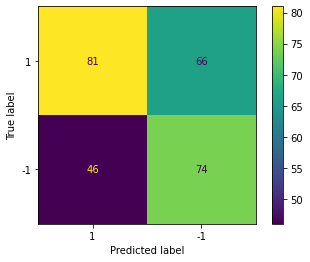

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_final, y_pred, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels= [1, -1])
disp.plot()

plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test_final, y_pred)) 

              precision    recall  f1-score   support

        -1.0       0.53      0.62      0.57       120
         1.0       0.64      0.55      0.59       147

    accuracy                           0.58       267
   macro avg       0.58      0.58      0.58       267
weighted avg       0.59      0.58      0.58       267



In [18]:
test_spl = TimeSeriesSplit(n_splits = 5, max_train_size = 0, test_size = 50, gap = 0)

for (train, test) in test_spl.split(X_test_final):
    X_test = X_test_final.iloc[test]
    y_test = y_test_final.iloc[test]
    y_p = grid.predict(X_test)
    print("From ", test[0], " to ", test[-1])
    print("Accuracy", accuracy_score(y_test, y_p))
    print("F1", f1_score(y_test, y_p))

From  17  to  66
Accuracy 0.62
F1 0.6122448979591837
From  67  to  116
Accuracy 0.6
F1 0.6428571428571428
From  117  to  166
Accuracy 0.46
F1 0.4705882352941177
From  167  to  216
Accuracy 0.64
F1 0.6666666666666666
From  217  to  266
Accuracy 0.56
F1 0.56


In [19]:
t,fee= command(y_pred, Test.Close)

t[0]=t[0].tolist()
t= pd.DataFrame(t).transpose()
t.columns=['Close','Command','L','S','Total_gain','Position']
print(t,fee)

      Close  Command    L    S  Total_gain  Position
0    1326.0     -1.0  0.0  1.0       -0.15    1326.0
1    1315.0      1.0  1.0  0.0       10.70    1315.0
2    1318.5     -1.0  0.0  1.0       14.05    1318.5
3    1315.0     -1.0  0.0  1.0       14.05    1318.5
4    1315.0     -1.0  0.0  1.0       14.05    1318.5
..      ...      ...  ...  ...         ...       ...
262  1096.5      1.0  1.0  0.0      437.70    1102.6
263  1100.0      1.0  1.0  0.0      437.70    1102.6
264  1115.5     -1.0  0.0  1.0      450.45    1115.5
265  1114.0      1.0  1.0  0.0      451.80    1114.0
266  1119.1      1.0  1.0  0.0      451.80    1114.0

[267 rows x 6 columns] 112


451.800000000001 112


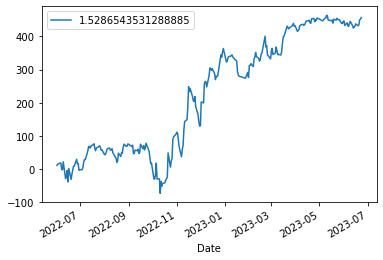

In [20]:
t,fee= command(y_pred,Test.Close)
t[0]=t[0].tolist()
t= pd.DataFrame(t).transpose()
t.columns=['Close','Command','L','S','Total_gain','Position']
t.index = Test.index
print(t.Total_gain.iloc[-1],fee) 
backtest, cash_max,pnl= portfolio_pnl_future(t,t.L,t.S,t.Close)
backtest.index = pd.to_datetime(backtest.index)
pnl = portfolio_pnl_future(t,t.L, t.S, t.Close)[0]
pnl.index = pd.to_datetime(pnl.index)

pnl = pnl.resample('1D').last().dropna()
backtest.plot(label = Sharp(backtest.resample('1D').last().dropna()))
plt.legend()

In [21]:
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("n_estimators")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
n_estimators,,,,
59,{'clf__n_estimators': 59},1,3.932325,2.474201
197,{'clf__n_estimators': 197},2,3.913341,2.560575
135,{'clf__n_estimators': 135},3,3.911430,2.543699
126,{'clf__n_estimators': 126},4,3.865736,2.143124
165,{'clf__n_estimators': 165},5,3.863638,2.689597
...,...,...,...,...
101,{'clf__n_estimators': 101},195,3.104077,2.044539
84,{'clf__n_estimators': 84},196,3.099293,2.111086
133,{'clf__n_estimators': 133},197,3.082589,2.224747


/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_3770/1144336053.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


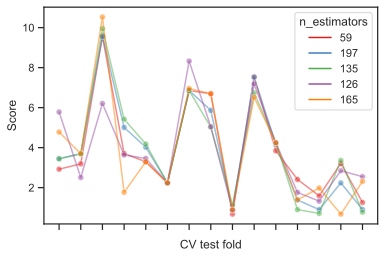

Correlation of models:
 n_estimators        59       197       135       126       165         5  \
n_estimators                                                               
59            1.000000  0.968029  0.939480  0.838255  0.911880  0.914581   
197           0.968029  1.000000  0.983117  0.853989  0.899502  0.893941   
135           0.939480  0.983117  1.000000  0.821764  0.852500  0.860583   
126           0.838255  0.853989  0.821764  1.000000  0.823563  0.859112   
165           0.911880  0.899502  0.852500  0.823563  1.000000  0.943362   
...                ...       ...       ...       ...       ...       ...   
101           0.925704  0.930938  0.895220  0.817189  0.837068  0.829589   
84            0.909827  0.901364  0.869930  0.751898  0.915321  0.901847   
133           0.807268  0.798178  0.742251  0.780915  0.736106  0.838740   
38            0.861089  0.897615  0.905393  0.758002  0.800493  0.842839   
16            0.808833  0.793434  0.704917  0.815204  0.804288  

In [22]:
import seaborn as sns
from IPython.display import set_matplotlib_formats

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:20,:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
set_matplotlib_formats('svg')

plt.savefig('increased_size_cv_ada.png')
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

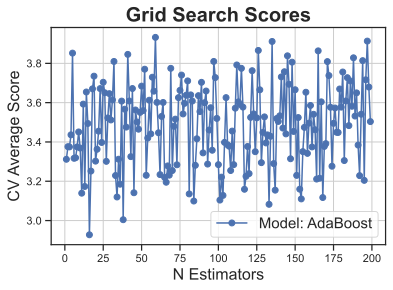

In [23]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid.cv_results_, range(1, 200), ['AdaBoost'], 'N Estimators', 'Model')
plt.savefig('ada_overfit.png')
